In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, img_as_ubyte, exposure
data_directory = os.path.join(os.getcwd(), "data")
output_directory = os.path.join(os.getcwd(), "results")
os.makedirs(output_directory, exist_ok=True)

In [2]:
print("Current Directory:", os.getcwd())
print("Data Directory:", data_directory)
print("Output Directory:", output_directory)

Current Directory: C:\Users\fek64mu\Desktop\Projects\TIFocus
Data Directory: C:\Users\fek64mu\Desktop\Projects\TIFocus\data
Output Directory: C:\Users\fek64mu\Desktop\Projects\TIFocus\results


In [3]:
# Load the multi-frame TIFF (Z-Stack)
def load_tif_zstack(file_path):
    img_stack = io.imread(file_path)
    print(f"Loaded image stack with shape: {img_stack.shape}")  # (Z, Y, X) or (Z, Y, X, C) if multichannel
    return img_stack

In [4]:
# Compute Laplacian variance for each Z-slice
def compute_laplacian_variance(img_stack):
    variances = [np.var(filters.laplace(img_stack[z])) for z in range(img_stack.shape[0])]
    return variances

In [5]:
# Visualize the slice with highest Laplacian variance
def show_highest_variance_slice(img_stack, variances, file_name):
    results_path = os.path.join(output_directory, f"{file_name}_analysis.png")
    max_variance_index = np.argmax(variances)
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(variances)), variances, marker='o', linestyle='-')
    plt.xlabel("Z-Slice Number")
    plt.ylabel("Laplacian Variance")
    plt.title("Laplacian Variance across Z-Slices")
    plt.grid(True)
    plt.xlim(0,20)
    
    plt.subplot(1, 2, 2)
    # Convert the slice with highest variance to 8-bit
    highest_variance_slice_8bit = exposure.rescale_intensity(img_as_ubyte(img_stack[max_variance_index]), out_range=(0, 255))
    plt.imshow(highest_variance_slice_8bit, cmap='gray')
    plt.title(f'Slice with Highest Variance (Z-Slice {max_variance_index})')
    plt.axis('off')
    # ===== debug =====
    print(f'Filename-{file_name}, has a min. value: {highest_variance_slice_8bit.min()}, a max. value: {highest_variance_slice_8bit.max()}')
    
    plt.tight_layout()
    plt.savefig(results_path)
    plt.show()
    #io.imsave(results_path, highest_variance_slice_8bit)
    print(f"The slice with the highest Laplacian variance is Z-Slice {max_variance_index}")

Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series01, has a min. value: 0.0, a max. value: 255.0


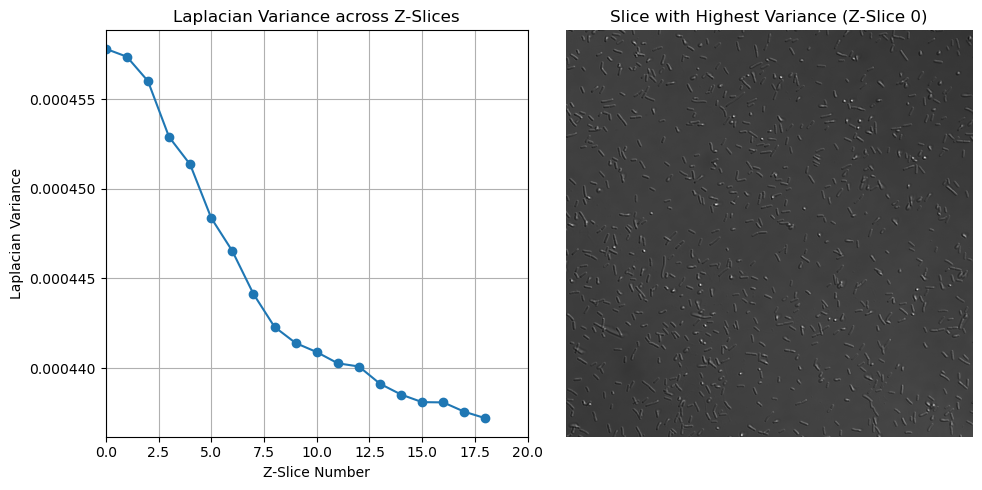

The slice with the highest Laplacian variance is Z-Slice 0


In [6]:
# Example usage
file_path = r"C:\Users\fek64mu\Desktop\Projects\TIFocus\data\WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series01.tif"
file_name = os.path.basename(file_path).split('.')[0]
img_stack = load_tif_zstack(file_path)
variances = compute_laplacian_variance(img_stack)
show_highest_variance_slice(img_stack, variances, file_name)

In [7]:
# Main batch analysis loop
def analyze_tif_stacks(data_directory):
    for filename in os.listdir(data_directory):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            file_path = os.path.join(data_directory, filename)
            print(f"Analyzing: {filename}")
            # Load the image stack
            img_stack = load_tif_zstack(file_path)
            # Compute Laplacian variance
            variances = compute_laplacian_variance(img_stack)
            # Show and save the slice with the highest variance
            show_highest_variance_slice(img_stack, variances, file_name=os.path.splitext(filename)[0])

Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series01.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series01, has a min. value: 0.0, a max. value: 255.0


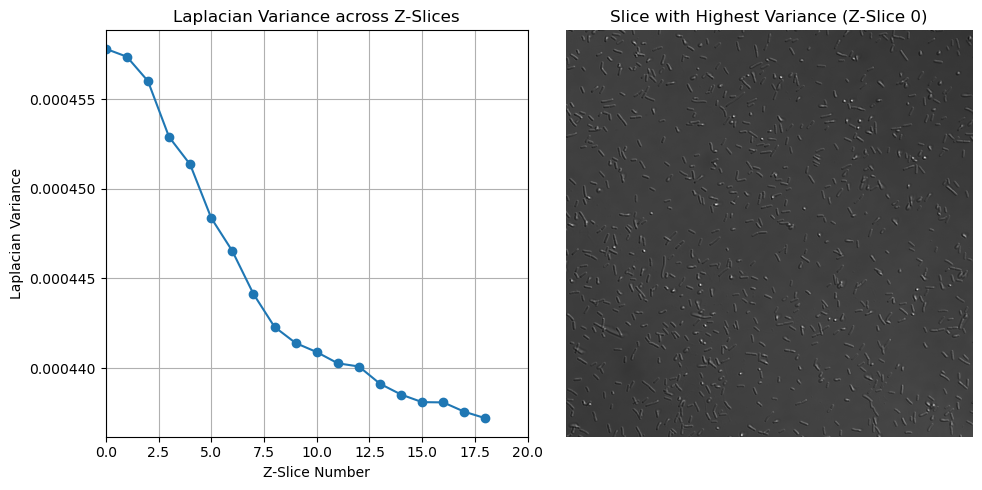

The slice with the highest Laplacian variance is Z-Slice 0
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series02.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series02, has a min. value: 0.0, a max. value: 255.0


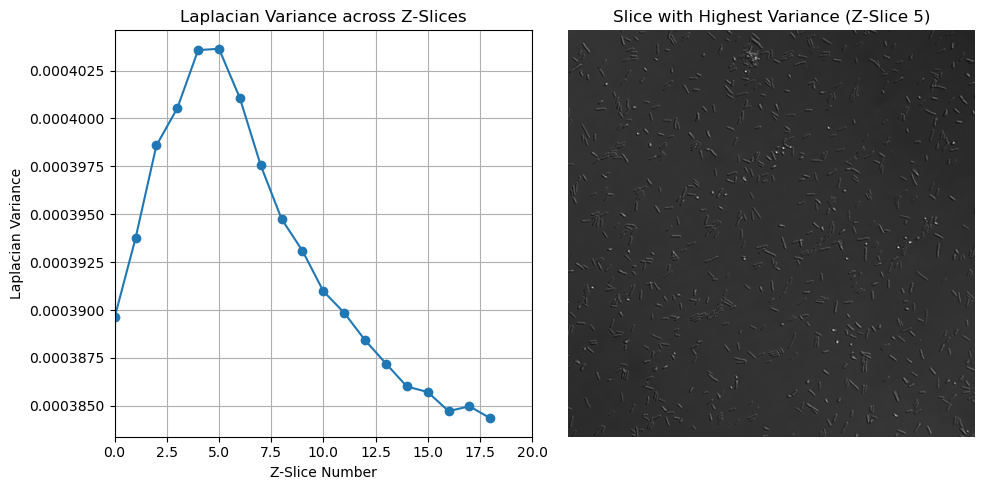

The slice with the highest Laplacian variance is Z-Slice 5
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series03.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series03, has a min. value: 0.0, a max. value: 255.0


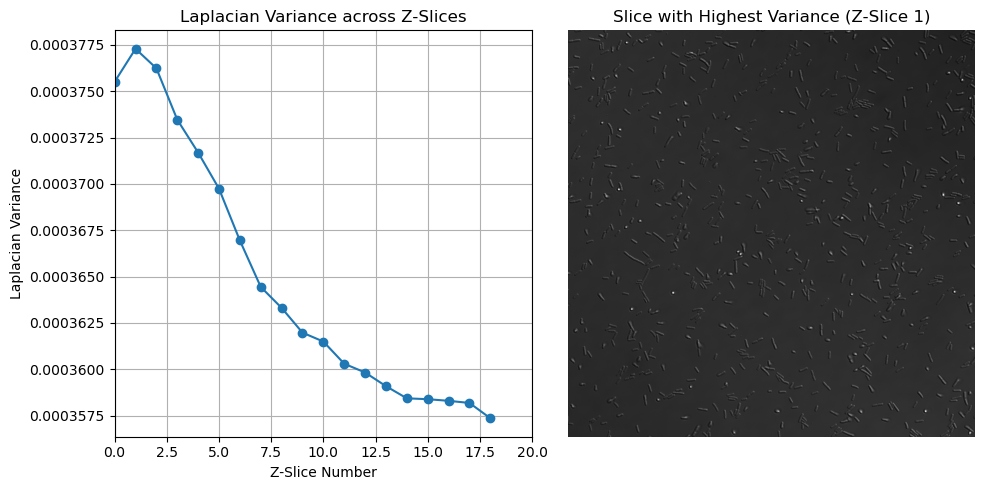

The slice with the highest Laplacian variance is Z-Slice 1
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series04.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series04, has a min. value: 0.0, a max. value: 255.0


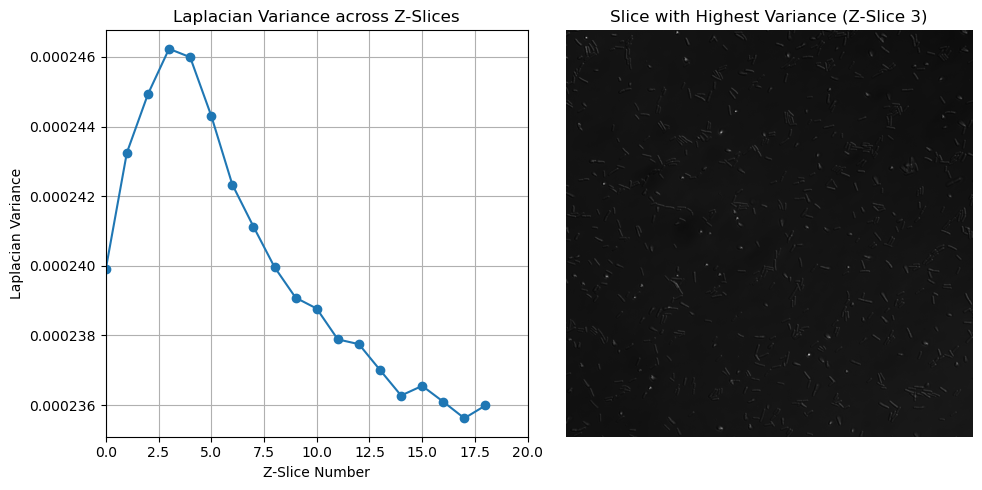

The slice with the highest Laplacian variance is Z-Slice 3
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series05.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series05, has a min. value: 0.0, a max. value: 255.0


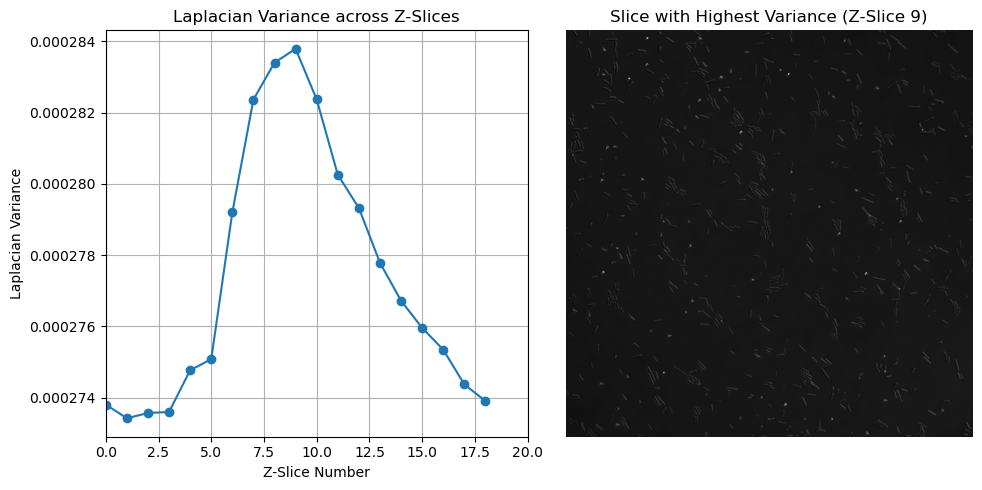

The slice with the highest Laplacian variance is Z-Slice 9
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series06.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series06, has a min. value: 0.0, a max. value: 255.0


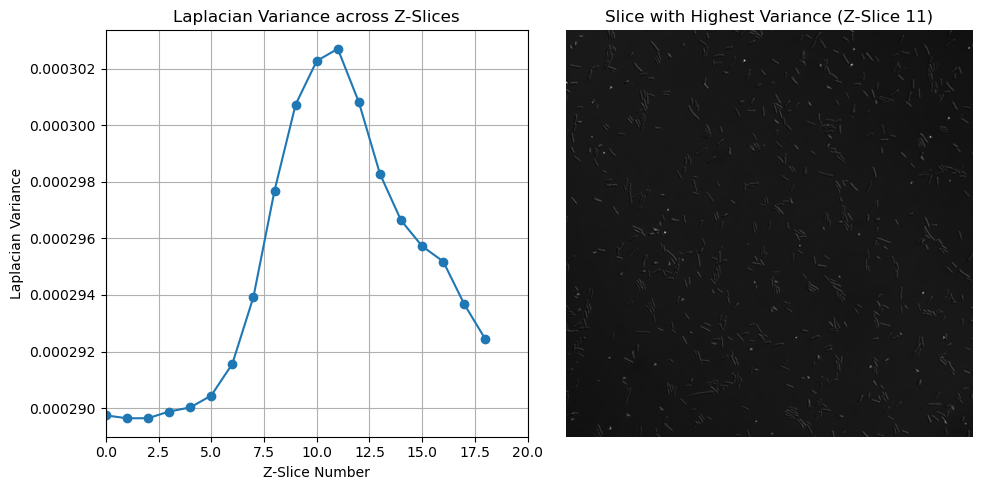

The slice with the highest Laplacian variance is Z-Slice 11
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series07.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series07, has a min. value: 0.0, a max. value: 255.0


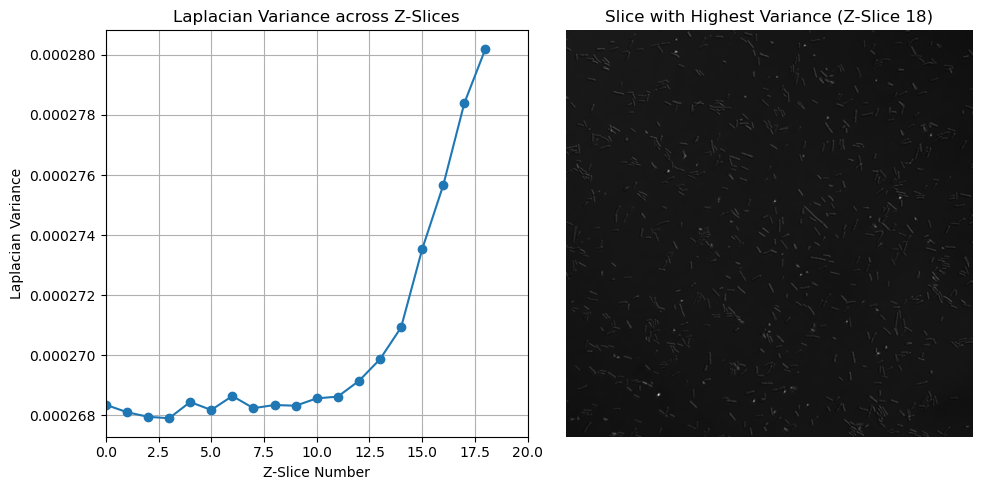

The slice with the highest Laplacian variance is Z-Slice 18
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series08.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series08, has a min. value: 0.0, a max. value: 255.0


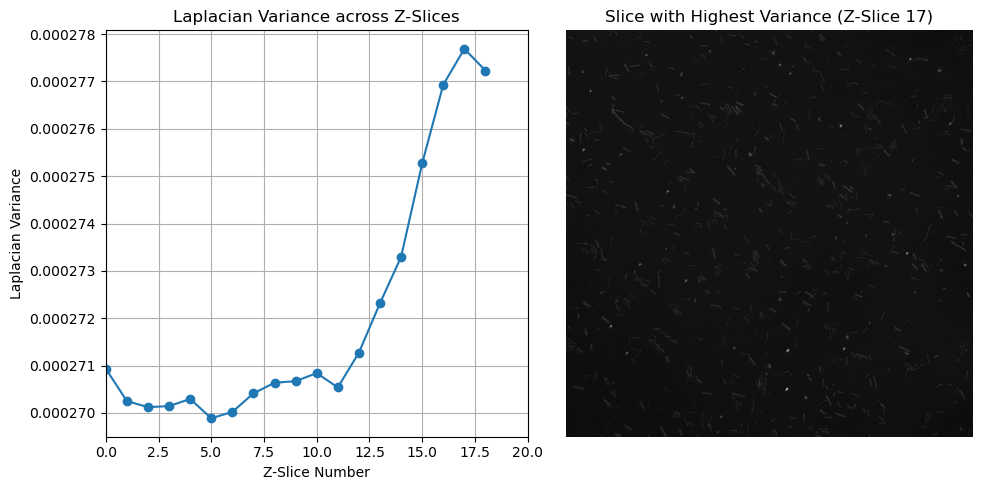

The slice with the highest Laplacian variance is Z-Slice 17
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series09.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series09, has a min. value: 0.0, a max. value: 255.0


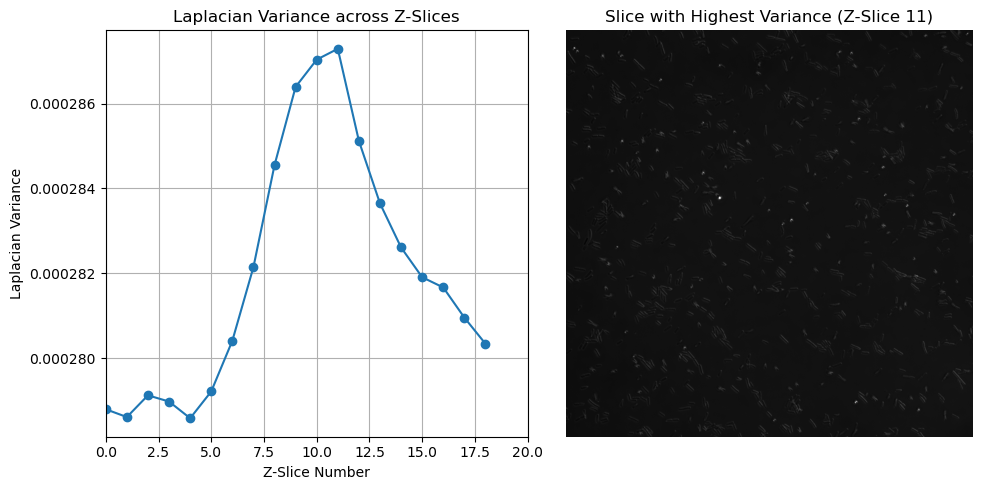

The slice with the highest Laplacian variance is Z-Slice 11
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series10.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series10, has a min. value: 0.0, a max. value: 255.0


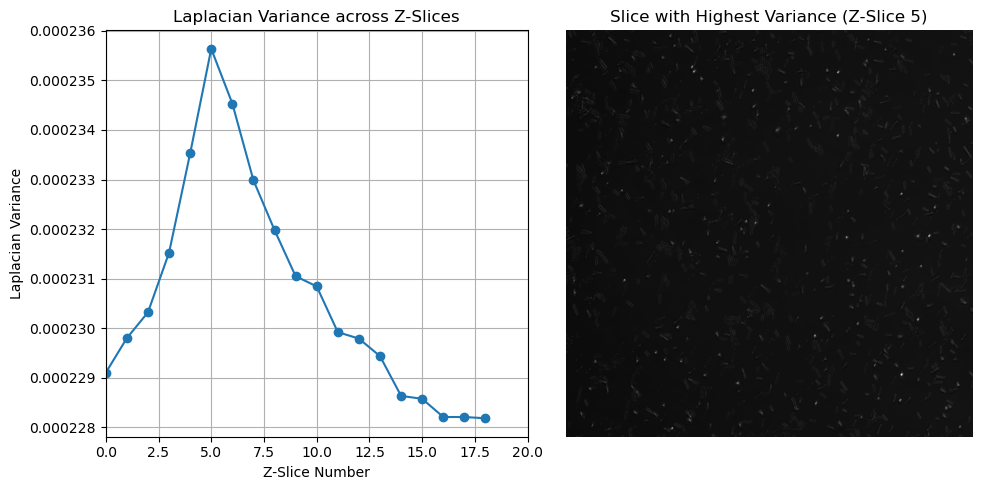

The slice with the highest Laplacian variance is Z-Slice 5


In [8]:
analyze_tif_stacks(data_directory)